In [1]:
%config IPCompleter.greedy = True
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import PIL 
import numpy as np
import random 

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [3]:
device = torch.device("cuda:0")

In [7]:
def show_images(img):
    img = img.numpy()
    img = np.transpose(img, (1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img*std + mean
    plt.figure(figsize = (20, 10))
    plt.imshow(img)
    plt.show()

In [11]:
def get_train_valid_loaders(root,
                            batch_size,
                            augment,
                            valid_size = 0.1,
                            shuffle = True,
                            num_workers = 2,
                            pin_memory = True
                            ):
    
    randomtransforms = [transforms.ColorJitter(hue=.05, saturation=.05),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)]
    
    if(augment):
        traintransforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomApply(randomtransforms, p = 0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        traintransforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    validtransforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
    
    train_dataset = ImageFolder(root, transform = traintransforms)
    valid_dataset = ImageFolder(root, transform = validtransforms)
    
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    
    if(shuffle):
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    
    trainiter = iter(train_loader)
    images, labels = next(trainiter)
    show_images(torchvision.utils.make_grid(images))
    print(labels)
    
    return(train_loader, valid_loader)    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


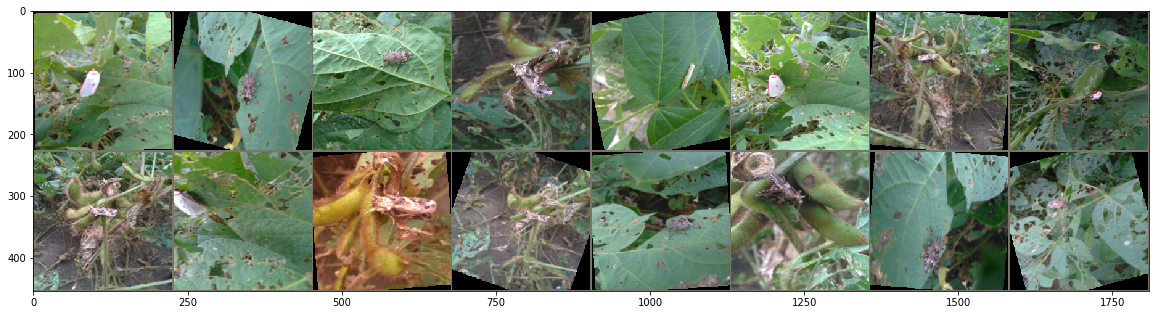

tensor([2, 0, 0, 3, 1, 2, 3, 2, 3, 2, 3, 3, 0, 3, 0, 0])


In [12]:
PATH = "/home/user/Documents/aditya_main/aditya/data/insects"
train_loader, valid_loader = get_train_valid_loaders(root = PATH, batch_size = 16, augment = True)

In [14]:
model = torchvision.models.mobilenet_v2(pretrained = True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/user/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 14212972/14212972 [00:01<00:00, 8625011.33it/s]
